In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional, Flatten, TimeDistributed, Reshape
import tensorflow as tf


# **8:2**

In [156]:
df = pd.read_csv('BNB.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,3/2/2019,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,3/3/2019,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,3/4/2019,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,3/5/2019,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1899,5/12/2024,592.029175,599.184143,587.804321,594.424560,594.424560,1276671115
1900,5/13/2024,594.424560,597.768005,585.520752,591.606934,591.606934,1636169234
1901,5/14/2024,591.606934,592.836975,563.420227,566.707031,566.707031,1944063031
1902,5/15/2024,566.707031,587.421509,561.127258,582.074341,582.074341,1895100260


In [157]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [158]:
# 4. Chia train test
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]


In [159]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [160]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [161]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [162]:
# 8. Define LSTM Model
# Define the CNN model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [163]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
23/23 [==============================] - 4s 88ms/step - loss: 0.0497 - val_loss: 0.0188
Epoch 2/200
23/23 [==============================] - 2s 75ms/step - loss: 0.0139 - val_loss: 0.0155
Epoch 3/200
23/23 [==============================] - 2s 75ms/step - loss: 0.0099 - val_loss: 0.0125
Epoch 4/200
23/23 [==============================] - 2s 97ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 5/200
23/23 [==============================] - 3s 119ms/step - loss: 0.0052 - val_loss: 0.0090
Epoch 6/200
23/23 [==============================] - 2s 73ms/step - loss: 0.0046 - val_loss: 0.0091
Epoch 7/200
23/23 [==============================] - 2s 74ms/step - loss: 0.0045 - val_loss: 0.0059
Epoch 8/200
23/23 [==============================] - 2s 73ms/step - loss: 0.0038 - val_loss: 0.0079
Epoch 9/200
23/23 [==============================] - 2s 74ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 10/200
23/23 [==============================] - 2s 72ms/step - loss: 0.0037 - val_loss: 0.004

In [164]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

9/9 [==============================] - 0s 16ms/step


In [165]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [166]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 15.456714883633271
Testing MAPE: 2.525855849026369
Testing MAE: 9.57361989638393


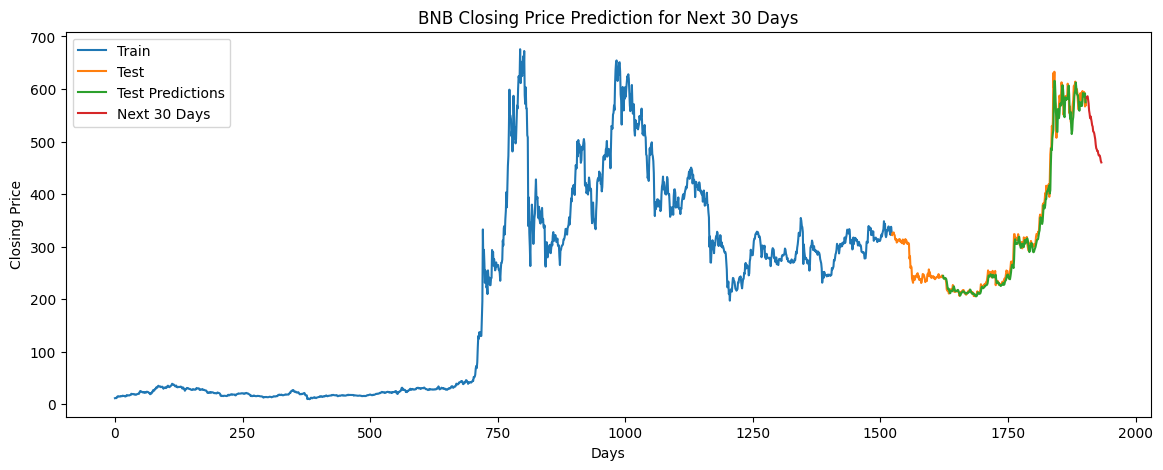

Predicted closing prices for the next 30 days:
[583.0996  584.9665  586.17993 580.3844  572.4602  559.17645 552.83545
 544.3188  547.90155 542.9905  537.64716 530.86536 528.59344 519.2261
 518.28595 515.8022  510.24777 504.52695 494.14606 487.19833 485.11743
 481.79156 482.14832 476.72302 473.458   473.3079  473.1777  468.73074
 462.76505 460.2012 ]


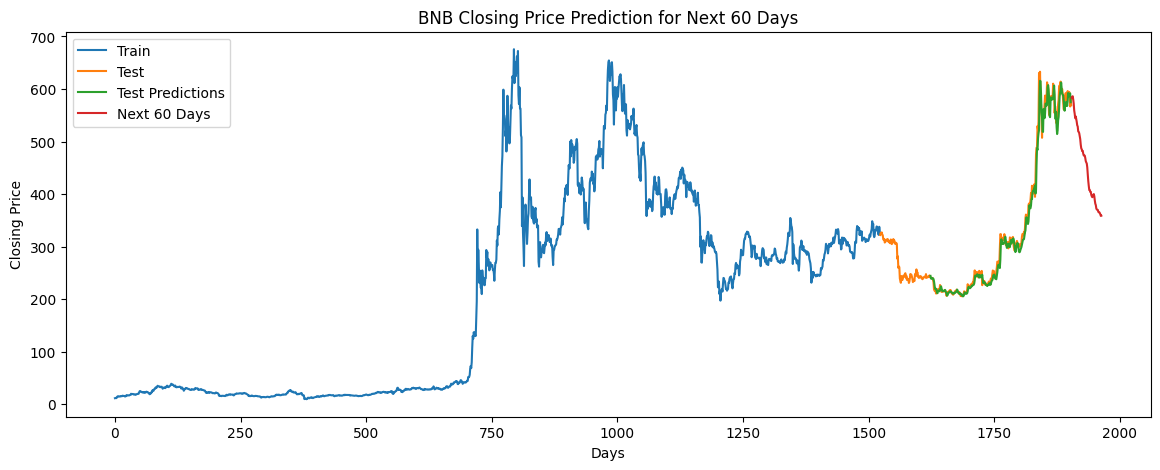

Predicted closing prices for the next 60 days:
[583.0996  584.9665  586.17993 580.3844  572.4602  559.17645 552.83545
 544.3188  547.90155 542.9905  537.64716 530.86536 528.59344 519.2261
 518.28595 515.8022  510.24777 504.52695 494.14606 487.19833 485.11743
 481.79156 482.14832 476.72302 473.458   473.3079  473.1777  468.73074
 462.76505 460.2012  458.12393 450.90424 437.3187  424.65674 415.28537
 407.6514  407.45926 404.19748 404.2161  398.39197 395.7284  393.99417
 396.08102 397.95355 399.92404 395.98483 387.74234 381.6461  378.91507
 372.5603  370.5193  370.0764  369.7584  366.0453  365.18683 365.29724
 363.71387 361.30414 358.2565  358.73123]


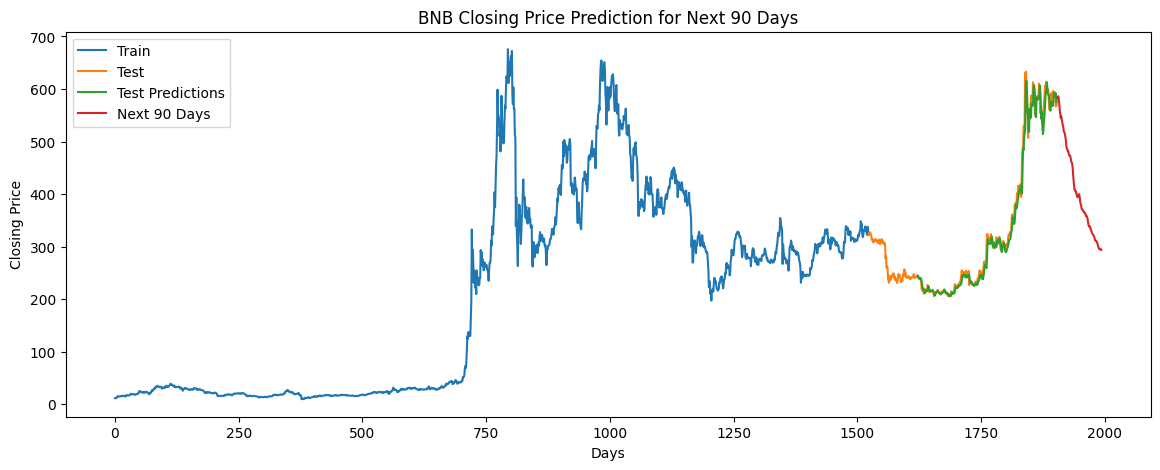

Predicted closing prices for the next 90 days:
[583.0996  584.9665  586.17993 580.3844  572.4602  559.17645 552.83545
 544.3188  547.90155 542.9905  537.64716 530.86536 528.59344 519.2261
 518.28595 515.8022  510.24777 504.52695 494.14606 487.19833 485.11743
 481.79156 482.14832 476.72302 473.458   473.3079  473.1777  468.73074
 462.76505 460.2012  458.12393 450.90424 437.3187  424.65674 415.28537
 407.6514  407.45926 404.19748 404.2161  398.39197 395.7284  393.99417
 396.08102 397.95355 399.92404 395.98483 387.74234 381.6461  378.91507
 372.5603  370.5193  370.0764  369.7584  366.0453  365.18683 365.29724
 363.71387 361.30414 358.2565  358.73123 356.44064 354.2121  347.03693
 341.8023  338.3472  338.1331  338.57126 335.1711  331.34442 329.67984
 326.28726 324.30472 323.114   321.39462 320.23395 317.64377 312.78842
 311.19876 311.41547 310.40308 309.22418 305.92673 302.31796 299.49387
 296.21393 294.91434 294.7157  295.69815 295.04565 293.66138]


In [167]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BNB Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **7:3**

In [168]:
df = pd.read_csv('BNB.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,3/2/2019,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,3/3/2019,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,3/4/2019,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,3/5/2019,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1899,5/12/2024,592.029175,599.184143,587.804321,594.424560,594.424560,1276671115
1900,5/13/2024,594.424560,597.768005,585.520752,591.606934,591.606934,1636169234
1901,5/14/2024,591.606934,592.836975,563.420227,566.707031,566.707031,1944063031
1902,5/15/2024,566.707031,587.421509,561.127258,582.074341,582.074341,1895100260


In [169]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [170]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [171]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [172]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [173]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [174]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [175]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
20/20 [==============================] - 4s 91ms/step - loss: 0.0450 - val_loss: 0.0111
Epoch 2/200
20/20 [==============================] - 2s 117ms/step - loss: 0.0147 - val_loss: 0.0088
Epoch 3/200
20/20 [==============================] - 2s 118ms/step - loss: 0.0089 - val_loss: 0.0062
Epoch 4/200
20/20 [==============================] - 2s 75ms/step - loss: 0.0060 - val_loss: 0.0053
Epoch 5/200
20/20 [==============================] - 2s 83ms/step - loss: 0.0060 - val_loss: 0.0047
Epoch 6/200
20/20 [==============================] - 2s 78ms/step - loss: 0.0049 - val_loss: 0.0061
Epoch 7/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 8/200
20/20 [==============================] - 2s 76ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 9/200
20/20 [==============================] - 2s 77ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 10/200
20/20 [==============================] - 3s 140ms/step - loss: 0.0034 - val_loss: 0.0

In [176]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

15/15 [==============================] - 0s 15ms/step


In [177]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [178]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 13.424534673556295
Testing MAPE: 2.6652766233590843
Testing MAE: 8.887614222936156


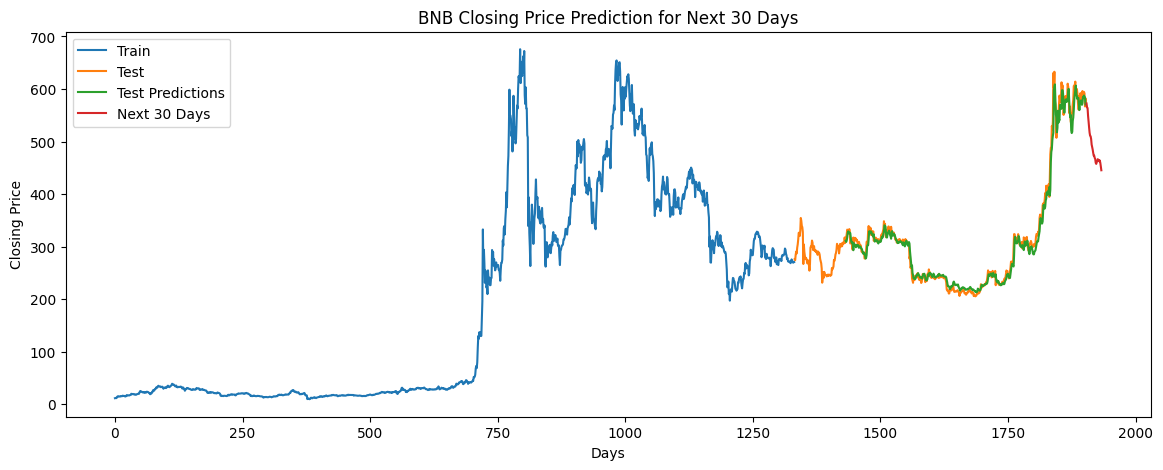

Predicted closing prices for the next 30 days:
[572.3931  564.71704 563.7622  548.8229  538.1452  526.88336 516.7392
 510.98477 509.9613  504.78708 494.1435  489.57672 484.80814 478.65665
 473.2337  473.1283  468.8588  466.76938 459.4931  457.3995  461.15384
 462.0761  466.3607  464.72382 464.55676 462.22842 463.914   459.28482
 452.48346 445.25616]


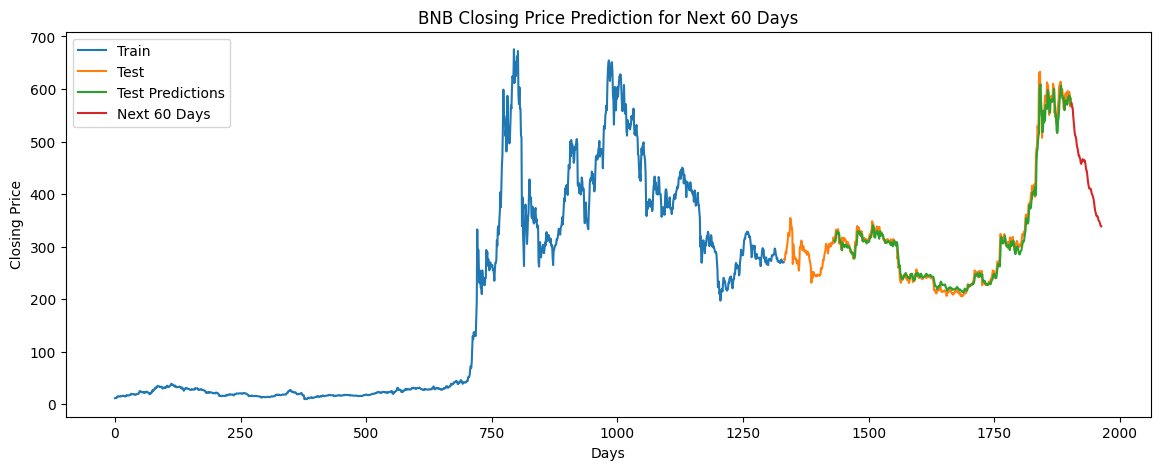

Predicted closing prices for the next 60 days:
[572.3931  564.71704 563.7622  548.8229  538.1452  526.88336 516.7392
 510.98477 509.9613  504.78708 494.1435  489.57672 484.80814 478.65665
 473.2337  473.1283  468.8588  466.76938 459.4931  457.3995  461.15384
 462.0761  466.3607  464.72382 464.55676 462.22842 463.914   459.28482
 452.48346 445.25616 444.31705 436.36124 427.28372 419.67776 414.29233
 410.29785 410.42206 410.29752 409.97873 404.9918  400.59515 398.8232
 395.6522  392.8286  387.21307 380.23526 372.634   366.64484 363.91724
 358.9481  357.56503 357.85678 356.48746 351.37927 349.0485  348.05322
 345.1981  341.5092  339.0819  338.52734]


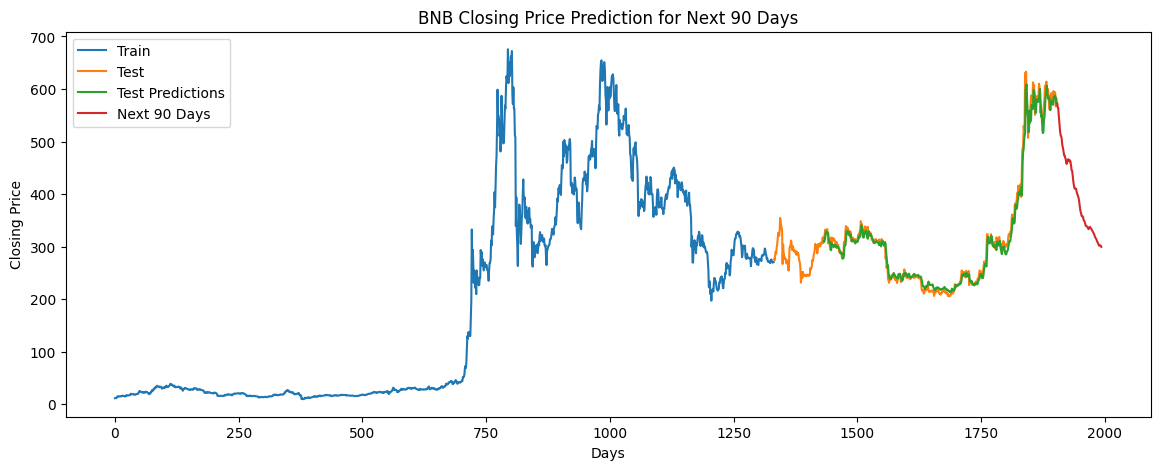

Predicted closing prices for the next 90 days:
[572.3931  564.71704 563.7622  548.8229  538.1452  526.88336 516.7392
 510.98477 509.9613  504.78708 494.1435  489.57672 484.80814 478.65665
 473.2337  473.1283  468.8588  466.76938 459.4931  457.3995  461.15384
 462.0761  466.3607  464.72382 464.55676 462.22842 463.914   459.28482
 452.48346 445.25616 444.31705 436.36124 427.28372 419.67776 414.29233
 410.29785 410.42206 410.29752 409.97873 404.9918  400.59515 398.8232
 395.6522  392.8286  387.21307 380.23526 372.634   366.64484 363.91724
 358.9481  357.56503 357.85678 356.48746 351.37927 349.0485  348.05322
 345.1981  341.5092  339.0819  338.52734 338.3708  337.74683 335.10245
 333.14667 333.91782 335.49387 337.5956  335.849   334.7577  333.5047
 331.49432 329.5157  328.2134  325.73358 324.73346 321.78036 318.85718
 316.7798  315.71335 313.6263  311.0586  308.91473 306.79715 304.90005
 302.19254 301.65582 302.22318 302.29147 301.31128 299.49933]


In [179]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BNB Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())

# **6:4**

In [180]:
df = pd.read_csv('BNB.csv')
df1 = df.reset_index()['Close']
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/1/2019,10.356931,11.607489,10.325634,11.393217,11.393217,117838677
1,3/2/2019,11.384693,11.915753,10.960816,11.869744,11.869744,120807894
2,3/3/2019,11.845305,11.964979,11.352064,11.537903,11.537903,89868246
3,3/4/2019,11.538013,11.599405,11.070543,11.545945,11.545945,89421231
4,3/5/2019,11.520388,13.841443,11.520388,13.811967,13.811967,237026335
...,...,...,...,...,...,...,...
1899,5/12/2024,592.029175,599.184143,587.804321,594.424560,594.424560,1276671115
1900,5/13/2024,594.424560,597.768005,585.520752,591.606934,591.606934,1636169234
1901,5/14/2024,591.606934,592.836975,563.420227,566.707031,566.707031,1944063031
1902,5/15/2024,566.707031,587.421509,561.127258,582.074341,582.074341,1895100260


In [181]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [182]:
# 4. Chia train test
train_size = int(0.6 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [183]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [184]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [185]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [186]:
# 8. Define LSTM Model
# Define the model
model = Sequential()

# Add a 1D convolutional layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(100,1)))

# Add a max pooling layer
model.add(MaxPooling1D(pool_size=2))

# Add another 1D convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))

# Add an LSTM layer
model.add(LSTM(100, activation='relu', return_sequences=True))

# Add a flatten layer
model.add(Flatten())

# Add a dense output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [187]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=200,batch_size=64,verbose=1)

Epoch 1/200
17/17 [==============================] - 4s 104ms/step - loss: 0.0377 - val_loss: 0.0147
Epoch 2/200
17/17 [==============================] - 1s 81ms/step - loss: 0.0147 - val_loss: 0.0068
Epoch 3/200
17/17 [==============================] - 1s 81ms/step - loss: 0.0102 - val_loss: 0.0065
Epoch 4/200
17/17 [==============================] - 1s 82ms/step - loss: 0.0070 - val_loss: 0.0055
Epoch 5/200
17/17 [==============================] - 1s 84ms/step - loss: 0.0058 - val_loss: 0.0061
Epoch 6/200
17/17 [==============================] - 2s 127ms/step - loss: 0.0051 - val_loss: 0.0086
Epoch 7/200
17/17 [==============================] - 2s 133ms/step - loss: 0.0047 - val_loss: 0.0055
Epoch 8/200
17/17 [==============================] - 1s 83ms/step - loss: 0.0046 - val_loss: 0.0098
Epoch 9/200
17/17 [==============================] - 1s 81ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 10/200
17/17 [==============================] - 1s 82ms/step - loss: 0.0040 - val_loss: 0.0

In [188]:
# 10. Dự báo dữ liệu test
train_predict=model.predict(X_train)
y_pred = model.predict(X_test)

21/21 [==============================] - 0s 15ms/step


In [189]:
# 11. Chuẩn hóa dữ liệu
train_predict=scaler.inverse_transform(train_predict)
y_pred =scaler.inverse_transform(y_pred)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [190]:
# 12. Đánh giá độ chính xác thuật toán
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_pred - ytest) / ytest)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 36.126311197875104
Testing MAPE: 11.740818472667046
Testing MAE: 31.53676989649797


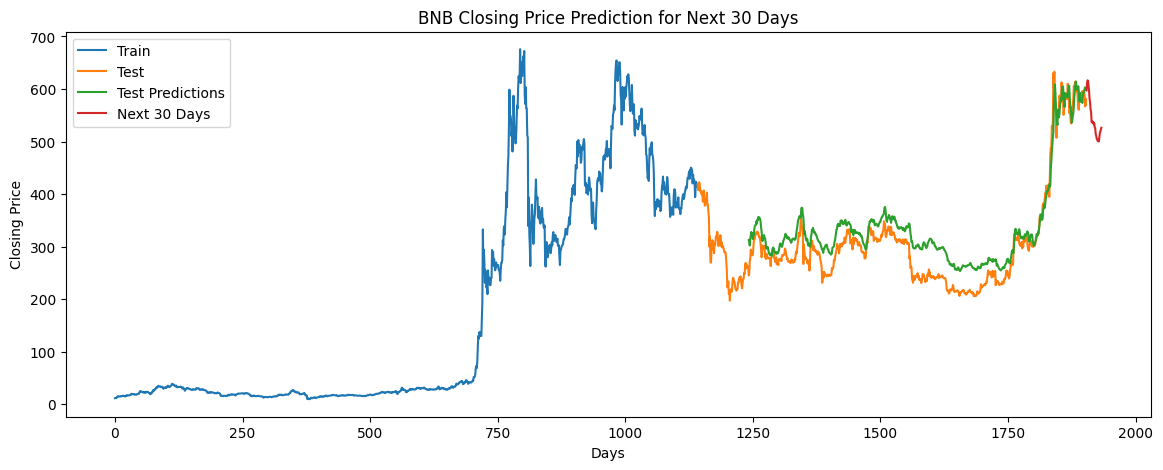

Predicted closing prices for the next 30 days:
[597.2532  610.4042  616.52203 615.01215 605.31177 595.4543  580.9988
 574.308   559.95557 555.704   536.6119  538.40436 535.4175  537.28906
 532.67773 535.39166 527.1553  525.3849  514.4322  510.48343 505.23743
 503.3878  501.0644  503.25613 500.02002 507.1878  514.75665 519.5364
 521.70605 526.145  ]


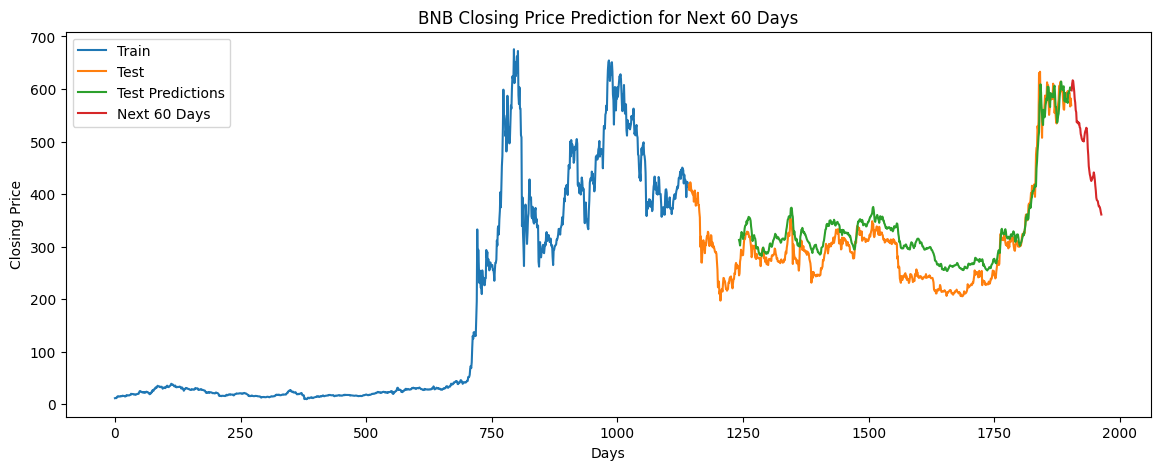

Predicted closing prices for the next 60 days:
[597.2532  610.4042  616.52203 615.01215 605.31177 595.4543  580.9988
 574.308   559.95557 555.704   536.6119  538.40436 535.4175  537.28906
 532.67773 535.39166 527.1553  525.3849  514.4322  510.48343 505.23743
 503.3878  501.0644  503.25613 500.02002 507.1878  514.75665 519.5364
 521.70605 526.145   525.0214  511.90216 486.86227 473.51022 453.10245
 445.28076 437.73697 433.57434 427.9486  424.8734  427.30667 428.9011
 432.88266 434.17087 441.1171  436.2888  427.41748 415.84106 406.52213
 393.12497 388.5995  387.51724 386.34195 380.51013 376.4102  376.34055
 374.7987  370.7827  365.23413 360.99353]


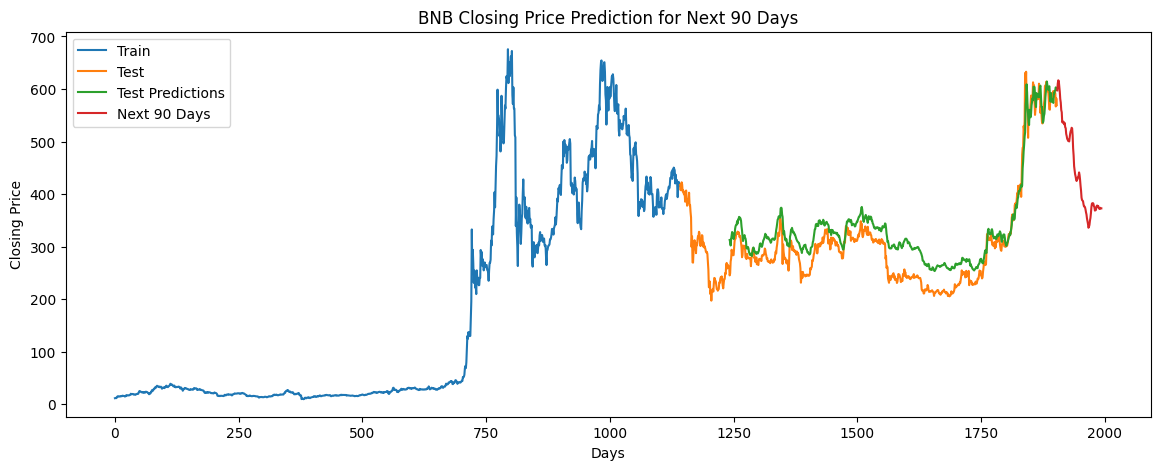

Predicted closing prices for the next 90 days:
[597.2532  610.4042  616.52203 615.01215 605.31177 595.4543  580.9988
 574.308   559.95557 555.704   536.6119  538.40436 535.4175  537.28906
 532.67773 535.39166 527.1553  525.3849  514.4322  510.48343 505.23743
 503.3878  501.0644  503.25613 500.02002 507.1878  514.75665 519.5364
 521.70605 526.145   525.0214  511.90216 486.86227 473.51022 453.10245
 445.28076 437.73697 433.57434 427.9486  424.8734  427.30667 428.9011
 432.88266 434.17087 441.1171  436.2888  427.41748 415.84106 406.52213
 393.12497 388.5995  387.51724 386.34195 380.51013 376.4102  376.34055
 374.7987  370.7827  365.23413 360.99353 353.37164 348.41916 343.16953
 335.7872  337.73782 341.18246 349.38254 354.63898 363.91318 375.54153
 381.7996  382.54883 382.63266 381.31018 376.84183 374.99472 368.55392
 369.0313  369.5593  375.3332  377.88422 377.90005 375.9997  376.61472
 372.5869  373.09    371.8034  373.71484 372.77924 372.70474]


In [191]:
# 13. Dự đoán 30, 60, 90 ngày tiếp theo
def predict_future(model, data, time_step, days):
    temp_input = list(data[:, 0])  # Extract the values as a 1D list
    lst_output = []
    i = 0
    while(i < days):
        if(len(temp_input) > time_step):
            x_input = np.array(temp_input[-time_step:])
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
        else:
            x_input = np.array(temp_input)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.append(yhat[0][0])  # Append the single predicted value
            lst_output.append(yhat[0][0])
            i = i + 1
    return np.array(lst_output).reshape(-1, 1)

last_100_days = df1[-time_step:]
future_days = [30, 60, 90]
for days in future_days:
    future_predictions = predict_future(model, last_100_days, time_step, days)
    future_predictions = scaler.inverse_transform(future_predictions)

    # Vẽ hình
    plt.figure(figsize=(14, 5))
    plt.plot(range(len(train_data)), scaler.inverse_transform(train_data), label='Train')
    plt.plot(range(len(train_data), len(train_data) + len(test_data)), scaler.inverse_transform(test_data), label='Test')
    plt.plot(range(len(train_data) + time_step, len(train_data) + time_step + len(y_pred)), y_pred, label='Test Predictions')
    future_index = range(len(df1), len(df1) + days)
    plt.plot(future_index, future_predictions, label=f'Next {days} Days')

    plt.xlabel('Days')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.title(f'BNB Closing Price Prediction for Next {days} Days')
    plt.show()

    print(f'Predicted closing prices for the next {days} days:')
    print(future_predictions.flatten())